**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent the problems while reloading the Project. The third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING THE DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the Project in one particular cell.

In [3]:
#@ DOWNLOADING ALL THE LIBRARIES AND DEPENDENCIES: UNCOMMENT BELOW:
# !pip install -U d2l

import os, requests, zipfile, tarfile, hashlib
import pandas as pd
import numpy as np

from d2l import torch as d2l
import torch
from torch import nn

**DEPENDENCIES FOR GETTING THE DATA:**
- I will define a **download** function which downloads the dataset. Similarly, I will implement two utility functions: one is to download and extract a **ZIP/TAR** files and other to download all the datasets. 

In [4]:
#@ DEPENDENCIES FOR GETTING THE DATA:
DATA_HUB = dict()                                                         # Maps the string to tuple containing the URL. 
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'                 # Location of the Dataset. 
#@ DEPENDENCIES FOR GETTING THE DATA:
def download(name, cache_dir=os.path.join("..", "data")):                 # Function for Downloading the Dataset. 
  assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split("/")[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, "rb") as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname
  print(f"Downloading {fname} from {url}...")
  r = requests.get(url, stream=True, verify=True)
  with open(fname, "wb") as f:
    f.write(r.content)
  return fname
#@ DEPENDENCIES FOR GETTING THE DATA:
def download_extract(name, folder=None):                                   # Downloading and Extracting a ZIP/TAR file. 
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == ".zip":
    fp = zipfile.ZipFile(fname, "r")
  elif ext in (".tar", ".gz"):
    fp = tarfile.open(fname, "r")
  else:
    assert False, "Only ZIP/TAR files can be extracted"
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir
#@ DEPENDENCIES FOR GETTING THE DATA:
def download_all():                                                        # Downloads all files in DATA HUB. 
  for name in DATA_HUB:
    download(name)

**GETTING THE DATA:**
- I have used google colab for this project so the process of reading the data might be different in other platforms. I am using the [**House Prices- Advanced Regression Techniques**](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) dataset. I will predict sales prices from this dataset. One can manually download the dataset and work on it. I will work with the dataset using the scripts below. 

In [6]:
#@ GETTING THE DATA:
DATA_HUB["house_train"] = (DATA_URL + 'kaggle_house_pred_train.csv', 
                           '585e9cc93e70b39160e7921475f9bcd7d31219ce')                  # Training Dataset. 
DATA_HUB["house_test"] = (DATA_URL + 'kaggle_house_pred_test.csv', 
                          'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')                   # Test Dataset. 
#@ GETTING THE DATA:
train_data = pd.read_csv(download("house_train"))                                       # Reading the Training Dataset. 
test_data = pd.read_csv(download("house_test"))                                         # Reading the Test Dataset. 
#@ INSPECTING THE DATA:
print(train_data.shape, test_data.shape)                                                # Inspecting the shape of Dataset. 
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])                                   # Inspecting the Dataset. 

(1460, 81) (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


**DATA PREPROCESSING:**
- I will preprocess the data before starting modeling. I will replace all the missing values by the corresponding feature's mean. I will standardize the data by rescaling features to zero mean and unit variance for the convenience of optimization.  

In [7]:
#@ DATA PREPROCESSING: NUMERICAL FEATURES:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))             # Concatenating all the Features. 
numeric_features = all_features.dtypes[all_features.dtypes != "object"].index           # Index of Numerical Features. 
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))                                               # Standardizing the Dataset. 
all_features[numeric_features] = all_features[numeric_features].fillna(0)               # Dealing with missing values. 
#@ DATA PREPROCESSING: DISCRETE FEATURES:
all_features = pd.get_dummies(all_features, dummy_na=True)                              # One Hot Encoding of the Discrete Features. 
all_features.shape                                                                      # Inspecting the shape of the Features. 

(2919, 331)

**DATA PREPARATION:**
- The values attribute can extract numpy format from pandas format. I will convert the numpy arrays into tensors representation for training. 

In [8]:
#@ DATA PREPARATION:
n_train = train_data.shape[0]                                                             # Number of Training Dataset. 
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)         # Converting the arrays into Tensors. 
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)          # Converting the arrays into Tensors. 
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)                      # Converting into Tensors. 
print("DATA PREPARATION is completed successfully!")                                      # Finalizing the result. 

DATA PREPARATION is completed successfully!


**TRAINING THE MODEL:**
- I will train a linear model with squared loss. The linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models. I will define the training function which rely on the adam optimizer. 

In [9]:
#@ SIMPLE LINEAR MODEL: 
loss = nn.MSELoss()                                                         # Initializing the Loss Function. 
input_features = train_features.shape[1]                                    # Shape of Input Features. 
#@ SIMPLE LINEAR MODEL:
def get_net():                                                              # Defining Simple Linear Model. 
  net = nn.Sequential(nn.Linear(input_features, 1))                         # Implementation of the Sequential API. 
  return net 
#@ IMPLEMENTATION OF ROOT MEAN SQUARED ERROR:
def log_rmse(net, features, labels):                                        # Defining the Root Mean Squared Error Function. 
  clipped_preds = torch.clamp(net(features), 1, float("inf"))
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))      # Calculating the RMSE.  
  return rmse.item()

In [10]:
#@ DEFINING THE TRAINING FUNCTION:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):             # Defining the Training Function. 
  train_ls, test_ls = [], []                                                # Initializing the empty lists. 
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, 
                               weight_decay=weight_decay)                   # Initializing the Adam Optimizer. 
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()                                                 # Initializing the Gradients. 
      l = loss(net(X), y)                                                   # Implementation of Loss Function. 
      l.backward()                                                          # Implementation of Backpropagation. 
      optimizer.step()                                                      # Optimization.  
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

**KFOLD CROSS VALIDATION:**
- It is used to select the model design and to adjust the hyperparameters. At first, I will define a function that returns the fold of the data in a K Fold Cross Validation.

In [11]:
#@ KFOLD CROSS VALIDATION:
def get_k_fold_data(k, i, X, y):                                            # Defining the function to get KFold Data.  
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j * fold_size, (j + 1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == 1:
      X_valid, y_valid = X_part, y_part 
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid                                 # Function to get KFold Data. 
#@ KFOLD CROSS VALIDATION:
def kfold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, 
          batch_size):                                                      # Defining the function for Cross Validation. 
  train_l_sum, valid_l_sum = 0, 0                                           # Initializing the Training and Validation Loss. 
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)                          # Getting the fold of Data. 
    net = get_net()                                                         # Initializing the Simpel Linear Model. 
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                               weight_decay, batch_size)                    # Training the Model. 
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
               xlabel="epoch", ylabel="rmse", xlim=[1, num_epochs],
               legend=["train", "valid"], yscale="log")
    print(f"fold {i + 1}, train log rmse {float(train_ls[-1]):f}, "
          f"valid log rmse {float(valid_ls[-1]):f}")
  return train_l_sum / k, valid_l_sum / k                           

**MODEL SELECTION:**

fold 1, train log rmse 0.367958, valid log rmse 0.384082
fold 2, train log rmse 0.368799, valid log rmse 0.384598
fold 3, train log rmse 0.368348, valid log rmse 0.384881
fold 4, train log rmse 0.367820, valid log rmse 0.384307
fold 5, train log rmse 0.368421, valid log rmse 0.384677
5 fold validation: avg train log rmse: 0.368269, avg valid log rmse: 0.384509


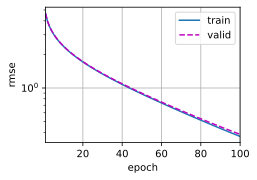

In [12]:
#@ MODEL SELECTION:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 2, 0.5, 64                # Initializing the Parameters. 
train_l, valid_l = kfold(k, train_features, train_labels, num_epochs, lr, 
                         weight_decay, batch_size)                              # Implementation of KFold. 
print(f"{k} fold validation: avg train log rmse: {float(train_l):f}, "
      f"avg valid log rmse: {float(valid_l):f}")

**MODEL EVALUATION:**

train log rmse 0.270043


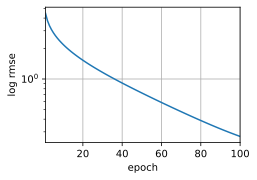

In [13]:
#@ MODEL EVALUATION:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):                         # Defining the Function for Model Evaluation. 
  net = get_net()                                                                     # Initializing the Simple Linear Model. 
  train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, 
                      weight_decay, batch_size)                                       # Training the Model. 
  d2l.plot(np.arange(1, num_epochs + 1), train_ls, 
           xlabel="epoch", ylabel="log rmse", xlim=[1, num_epochs],
           yscale="log")                                                              # Inspecting the Model. 
  print(f"train log rmse {float(train_ls[-1]):f}")
#@ MODEL EVALUATION:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs,
               lr, weight_decay, batch_size)